# Classification with Support Vector Machines

#### by Soeren Sonnenburg | Saurabh Mahindre - <a href=\"https://github.com/Saurabh7\">github.com/Saurabh7</a> as a part of <a href=\"http://www.google-melange.com/gsoc/project/details/google/gsoc2014/saurabh7/5750085036015616\">Google Summer of Code 2014 project</a> mentored by - Heiko Strathmann - <a href=\"https://github.com/karlnapf\">github.com/karlnapf</a> - <a href=\"http://herrstrathmann.de/\">herrstrathmann.de</a>

This notebook illustrates how to train a <a href="http://en.wikipedia.org/wiki/Support_vector_machine">Support Vector Machine</a> (SVM) <a href="http://en.wikipedia.org/wiki/Statistical_classification">classifier</a> using Shogun. The <a href="http://www.shogun-toolbox.org/doc/en/3.0.0/classshogun_1_1CLibSVM.html">CLibSVM</a> class of Shogun is used to do binary classification. Multiclass classification is also demonstrated using [CGMNPSVM](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGMNPSVM.html).

1. [Introduction](#Introduction)
2. [Linear Support Vector Machines](Linear-Support-Vector-Machines)
  1. [Prediction using Linear SVM](#Prediction-using-Linear-SVM)
3. [SVMs using kernels](#SVMs-using-kernels)
  1. [Kernels in Shogun](#Kernels-in-Shogun)
  2. [Prediction using kernel based SVM](#Prediction-using-kernel-based-SVM)
4. [Probabilistic Outputs using SVM](#Probabilistic-Outputs)
5. [Soft margins and slack variables](#Soft-margins-and-slack-variables)
6. [Binary classification using different kernels](#Binary classification-using-different-kernels)
7. [Kernel Normalizers](#Kernel-Normalizers)
8. [Multiclass classification using SVM](#Multiclass-classification)


### Introduction

Support Vector Machines (SVM's) are a learning method used for binary classification. The basic idea is to find a hyperplane which separates the data into its two classes. However, since example data is often not linearly separable, SVMs operate in a kernel induced feature space, i.e., data is embedded into a higher dimensional space where it is linearly separable.

### Linear Support Vector Machines

In a supervised learning problem, we are given a labeled set of input-output pairs $\mathcal{D}=(x_i,y_i)^N_{i=1}\subseteq \mathcal{X} \times \mathcal{Y}$ where $x\in\mathcal{X}$ and $y\in\{-1,+1\}$. [SVM](https://en.wikipedia.org/wiki/Support_vector_machine) is a binary classifier that tries to separate objects of different classes by finding a (hyper-)plane such that the margin between the two classes is maximized. A hyperplane in $\mathcal{R}^D$ can be parameterized by a vector $\bf{w}$ and a constant $\text b$ expressed in the equation:$${\bf w}\cdot{\bf x} + \text{b} = 0$$
Given such a hyperplane ($\bf w$,b) that separates the data, the discriminating function is: $$f(x) = \text {sign} ({\bf w}\cdot{\bf x} + {\text b})$$

If the training data are linearly separable, we can select two hyperplanes in a way that they separate the data and there are no points between them, and then try to maximize their distance. The region bounded by them is called "the margin". These hyperplanes can be described by the equations
$$({\bf w}\cdot{\bf x} + {\text b}) = 1$$
$$({\bf w}\cdot{\bf x} + {\text b}) = -1$$
the distance between these two hyperplanes is $\frac{2}{\|\mathbf{w}\|}$, so we want to minimize $\|\mathbf{w}\|$.
$$
    \arg\min_{(\mathbf{w},b)}\frac{1}{2}\|\mathbf{w}\|^2  \qquad\qquad(1)$$
This gives us a hyperplane that maximizes the geometric distance to the closest data points.
As we also have to prevent data points from falling into the margin, we add the following constraint: for each ${i}$ either
$$({\bf w}\cdot{x}_i + {\text b}) \geq 1$$ or
$$({\bf w}\cdot{x}_i + {\text b}) \leq -1$$
which is similar to
$${y_i}({\bf w}\cdot{x}_i + {\text b}) \geq 1   \forall i$$

[Lagrange multipliers](http://en.wikipedia.org/wiki/Lagrange_multiplier) are used to modify equation $(1)$ and the corresponding dual of the  problem can be shown to be:

  \begin{eqnarray*}
       \max_{\bf \alpha} && \sum_{i=1}^{N} \alpha_i - \sum_{i=1}^{N}\sum_{j=1}^{N} \alpha_i y_i \alpha_j y_j  {\bf x_i} \cdot {\bf x_j}\\
       \mbox{s.t.} && \alpha_i\geq 0\\
                   && \sum_{i}^{N} \alpha_i y_i=0\\
\end{eqnarray*}

From the derivation of these equations, it was seen that the optimal hyperplane can be written as:
$$\mathbf{w} = \sum_i \alpha_i y_i \mathbf{x}_i.  $$
here most $\alpha_i$ turn out to be zero, which means that the solution is a sparse linear combination of the training data.

### Prediction using Linear SVM

Now let us see how one can train a linear Support Vector Machine with Shogun. Two dimensional data (having 2 attributes say: attribute1 and attribute2) is now sampled to demonstrate the classification.

Populating the interactive namespace from numpy and matplotlib


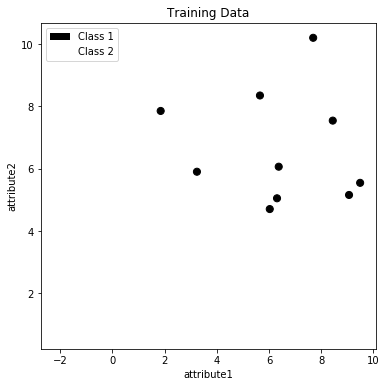

In [1]:
%pylab inline
%matplotlib inline
#To import all shogun classes
from shogun import *

#Generate some random data
X = 2 * random.randn(10,2)
traindata=r_[X + 3, X + 7].T

feats_train=RealFeatures(traindata)

trainlab=concatenate((ones(10),-ones(10)))
labels=BinaryLabels(trainlab)

# Plot the training data
figure(figsize=(6,6))
gray()
_=scatter(traindata[0, :], traindata[1,:], c=labels, s=50)
title("Training Data")
xlabel('attribute1')
ylabel('attribute2')
p1 = Rectangle((0, 0), 1, 1, fc="k")
p2 = Rectangle((0, 0), 1, 1, fc="w")
legend((p1, p2), ["Class 1", "Class 2"], loc=2)
gray()

[Liblinear](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLibLinear.html), a library for large- scale linear learning focusing on SVM, is used to do the classification. It supports different [solver types](http://www.shogun-toolbox.org/doc/en/latest/namespaceshogun.html#a6e99d1864c93fc2d41b1fa0fc253f471).

In [2]:
#prameters to svm
#parameter C is described in a later section.
C=1
epsilon=1e-3

svm=LibLinear(C, feats_train, labels)
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

#train
svm.train()
w=svm.get_w()
b=svm.get_bias()

We solve ${\bf w}\cdot{\bf x} + \text{b} = 0$ to visualise the separating hyperplane. The methods `get_w()` and `get_bias()` are used to get the necessary values.

RuntimeError: matplotlib does not support generators as input

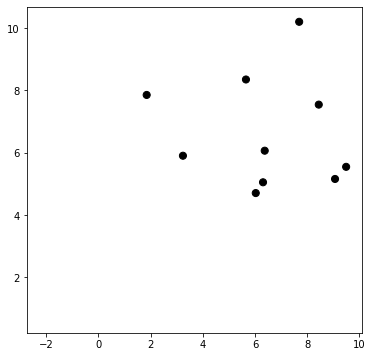

In [3]:
#solve for w.x+b=0
x1=linspace(-1.0, 11.0, 100)
def solve (x1):
    return -( ( (w[0])*x1 + b )/w[1] )

x2=map(solve, x1)

#plot
figure(figsize=(6,6))
gray()
_=scatter(traindata[0, :], traindata[1,:], c=labels, s=50)
_=plot(x1,x2, linewidth=2)
title("Separating hyperplane")
xlabel('attribute1')
ylabel('attribute2')
gray()

The classifier is now applied on a X-Y grid of points to get predictions.

/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'hold'
/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'hold'


<Figure size 432x288 with 0 Axes>

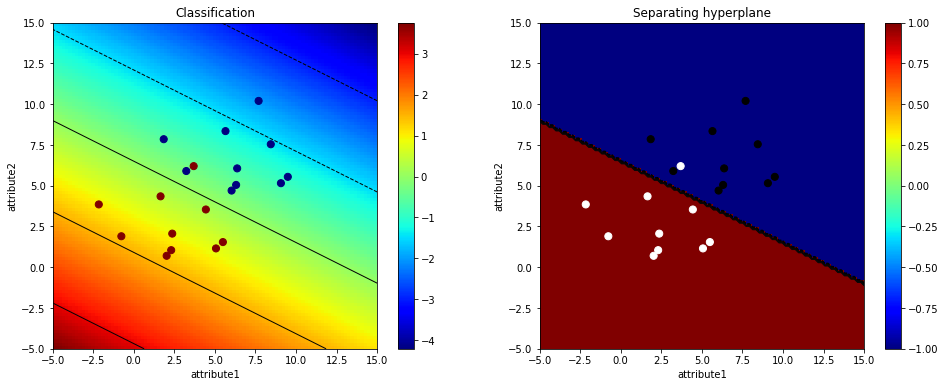

In [4]:
size=100
x1_=linspace(-5, 15, size)
x2_=linspace(-5, 15, size)
x, y=meshgrid(x1_, x2_)
#Generate X-Y grid test data
grid=RealFeatures(array((ravel(x), ravel(y))))

#apply on test grid
predictions = svm.apply(grid)

#Distance from hyperplane
z=predictions.get_values().reshape((size, size))

#plot
jet()
figure(figsize=(16,6))
subplot(121)
title("Classification")
c=pcolor(x, y, z)
_=contour(x, y, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)
gray()
_=scatter(traindata[0, :], traindata[1,:], c=labels, s=50)
xlabel('attribute1')
ylabel('attribute2')
jet()

#Class predictions
z=predictions.get_labels().reshape((size, size))

#plot
subplot(122)
title("Separating hyperplane")
c=pcolor(x, y, z)
_=contour(x, y, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)
gray()
_=scatter(traindata[0, :], traindata[1,:], c=labels, s=50)
xlabel('attribute1')
ylabel('attribute2')
gray()

### SVMs using kernels

If the data set is not linearly separable, a non-linear mapping $\Phi:{\bf x} \rightarrow \Phi({\bf x}) \in \mathcal{F} $ is used. This maps the data into a higher dimensional space where it is linearly separable. Our equation requires only the inner dot products ${\bf x_i}\cdot{\bf x_j}$. The equation can be defined in terms of inner products $\Phi({\bf x_i}) \cdot \Phi({\bf x_j})$ instead. Since  $\Phi({\bf x_i})$ occurs only in dot products with $ \Phi({\bf x_j})$ it is sufficient to know the formula ([kernel function](http://en.wikipedia.org/wiki/Kernel_trick)) : $$K({\bf x_i, x_j} ) =  \Phi({\bf x_i}) \cdot \Phi({\bf x_j})$$ without dealing with the maping directly. The transformed optimisation problem is:

\begin{eqnarray*} \max_{\bf \alpha} && \sum_{i=1}^{N} \alpha_i - \sum_{i=1}^{N}\sum_{j=1}^{N} \alpha_i y_i \alpha_j y_j k({\bf x_i}, {\bf x_j})\\ \mbox{s.t.} && \alpha_i\geq 0\\ && \sum_{i=1}^{N} \alpha_i y_i=0 \qquad\qquad(2)\\ \end{eqnarray*}

### Kernels in Shogun

Shogun provides many options for the above mentioned kernel functions. [CKernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKernel.html) is the base class for kernels. Some commonly used kernels : 

* [Gaussian kernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGaussianKernel.html) : Popular Gaussian kernel computed as $k({\bf x},{\bf x'})= exp(-\frac{||{\bf x}-{\bf x'}||^2}{\tau})$

* [Linear kernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLinearKernel.html) : Computes $k({\bf x},{\bf x'})= {\bf x}\cdot {\bf x'}$
* [Polynomial kernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CPolyKernel.html) : Polynomial kernel computed as $k({\bf x},{\bf x'})= ({\bf x}\cdot {\bf x'}+c)^d$

* [Simgmoid Kernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CSigmoidKernel.html) : Computes $k({\bf x},{\bf x'})=\mbox{tanh}(\gamma {\bf x}\cdot{\bf x'}+c)$

Some of these kernels are initialised below.

In [5]:
gaussian_kernel=GaussianKernel(feats_train, feats_train, 100)
#Polynomial kernel of degree 2
poly_kernel=PolyKernel(feats_train, feats_train, 2, True)
linear_kernel=LinearKernel(feats_train, feats_train)

kernels=[linear_kernel, poly_kernel, gaussian_kernel]

Just for fun we compute the kernel matrix and display it. There are clusters visible that are smooth for the gaussian and polynomial kernel and block-wise for the linear one. The gaussian one also smoothly decays from some cluster centre while the polynomial one oscillates within the clusters.

<Figure size 432x288 with 0 Axes>

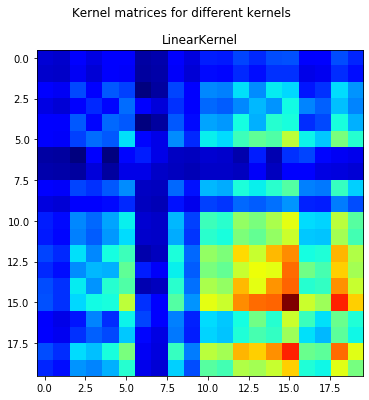

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

In [14]:
jet()
def display_km(kernels, svm):
    figure(figsize=(20,6))
    suptitle('Kernel matrices for different kernels', fontsize=12)
    for i, kernel in enumerate(kernels):
#         subplot(1, len(kernels)+1, i)
        title(kernel.get_name())
        km=kernel.get_kernel_matrix()
        _=imshow(km, interpolation="nearest")
        plt.show()
        _=colorbar()

display_km(kernels, svm)

### Prediction using kernel based SVM

Now we train an SVM with a Gaussian Kernel. We use LibSVM but we could use any of the [other SVM](http://www.shogun-toolbox.org/doc/en/current/classshogun_1_1CSVM.html) from Shogun. They all utilize the same kernel framework and so are drop-in replacements.

In [15]:
C=1
epsilon=1e-3
svm=LibSVM(C, gaussian_kernel, labels)
_=svm.train()

We could now check a number of properties like what the value of the objective function returned by the particular SVM learning algorithm or the explictly computed primal and dual objective function is

In [17]:
libsvm_obj=svm.get_objective()
primal_obj, dual_obj=svm.compute_svm_primal_objective(), svm.compute_svm_dual_objective()

print (libsvm_obj, primal_obj, dual_obj)

-9.095271319537472 -9.095271519823857 -9.095271485067412


and based on the objectives we can compute the duality gap (have a look at reference [2]), a measure of convergence quality of the svm training algorithm . In theory it is 0 at the optimum and in reality at least close to 0.

In [18]:
print ("duality_gap", dual_obj-primal_obj)

duality_gap 3.475644483330598e-08


Let's now apply on the X-Y grid data and plot the results.

/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'hold'
  # Remove the CWD from sys.path while we load stuff.
/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'hold'


<Figure size 432x288 with 0 Axes>

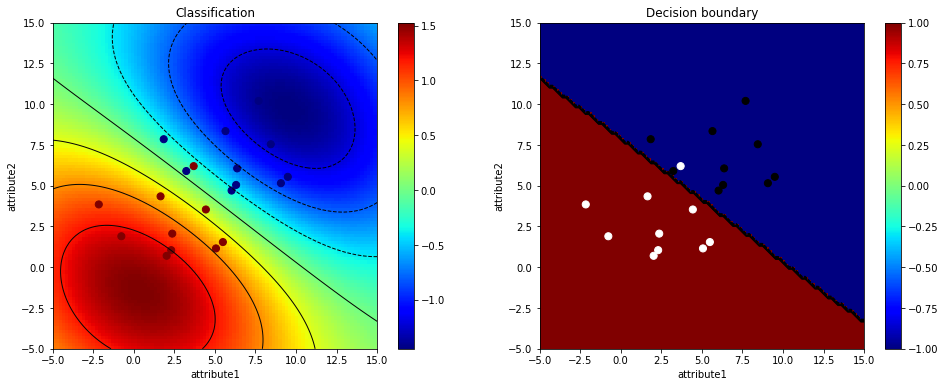

In [19]:
out=svm.apply(RealFeatures(grid))
z=out.get_values().reshape((size, size))

#plot
jet()
figure(figsize=(16,6))
subplot(121)
title("Classification")
c=pcolor(x1_, x2_, z)
_=contour(x1_ , x2_, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)

gray()
_=scatter(traindata[0, :], traindata[1,:], c=labels, s=50)
xlabel('attribute1')
ylabel('attribute2')
jet()

z=out.get_labels().reshape((size, size))
subplot(122)
title("Decision boundary")
c=pcolor(x1_, x2_, z)
_=contour(x1_ , x2_, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)

_=scatter(traindata[0, :], traindata[1,:], c=labels, s=50)
xlabel('attribute1')
ylabel('attribute2')
gray()


### Probabilistic Outputs

Calibrated probabilities can be generated in addition to class predictions using `scores_to_probabilities()` method of [BinaryLabels](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CBinaryLabels.html), which implements the method described in [3]. This should only be used in conjunction with SVM. A parameteric form of a [sigmoid function](http://en.wikipedia.org/wiki/Sigmoid_function) $$\frac{1}{{1+}exp(af(x) + b)}$$ is used to fit the outputs. Here $f(x)$ is the signed distance of a sample from the hyperplane, $a$ and $b$ are parameters to the sigmoid. This gives us the posterier probabilities $p(y=1|f(x))$.

Let's try this out on the above example. The familiar "S" shape of the sigmoid should be visible.

<Figure size 432x288 with 0 Axes>

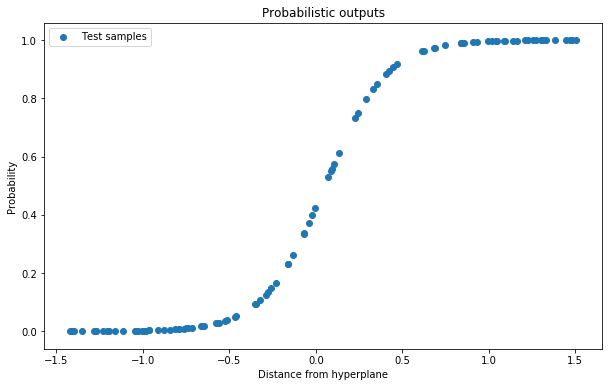

In [20]:
n=10
x1t_=linspace(-5, 15, n)
x2t_=linspace(-5, 15, n)
xt, yt=meshgrid(x1t_, x2t_)
#Generate X-Y grid test data
test_grid=RealFeatures(array((ravel(xt), ravel(yt))))

labels_out=svm.apply(RealFeatures(test_grid))

#Get values (Distance from hyperplane)
values=labels_out.get_values()

#Get probabilities
labels_out.scores_to_probabilities()
prob=labels_out.get_values()

#plot
gray()
figure(figsize=(10,6))
p1=scatter(values, prob)
title('Probabilistic outputs')
xlabel('Distance from hyperplane')
_=ylabel('Probability')
_=legend([p1], ["Test samples"], loc=2)

### Soft margins and slack variables

If there is no clear classification possible using a hyperplane, we need to classify the data as nicely as possible while incorporating the misclassified samples. To do this a concept of soft margin is used. The method introduces non-negative slack variables, $\xi_i$, which measure the degree of misclassification of the data $x_i$.
$$
    y_i(\mathbf{w}\cdot\mathbf{x_i} + b) \ge 1 - \xi_i \quad 1 \le i \le N  $$

Introducing a linear penalty function leads to 
$$\arg\min_{\mathbf{w},\mathbf{\xi}, b } ({\frac{1}{2} \|\mathbf{w}\|^2 +C \sum_{i=1}^n \xi_i) }$$

This in its dual form is leads to a slightly modified equation $\qquad(2)$.
\begin{eqnarray*} \max_{\bf \alpha} && \sum_{i=1}^{N} \alpha_i - \sum_{i=1}^{N}\sum_{j=1}^{N} \alpha_i y_i \alpha_j y_j k({\bf x_i}, {\bf x_j})\\ \mbox{s.t.} && 0\leq\alpha_i\leq C\\ && \sum_{i=1}^{N} \alpha_i y_i=0 \\ \end{eqnarray*}

The result is that soft-margin SVM could choose decision boundary that has non-zero training error even if dataset is linearly separable but is less likely to overfit.

Here's an example using LibSVM on the above used data set. Highlighted points show support vectors. This should visually show the impact of C and how the amount of outliers on the wrong side of hyperplane is controlled using it.

/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'hold'


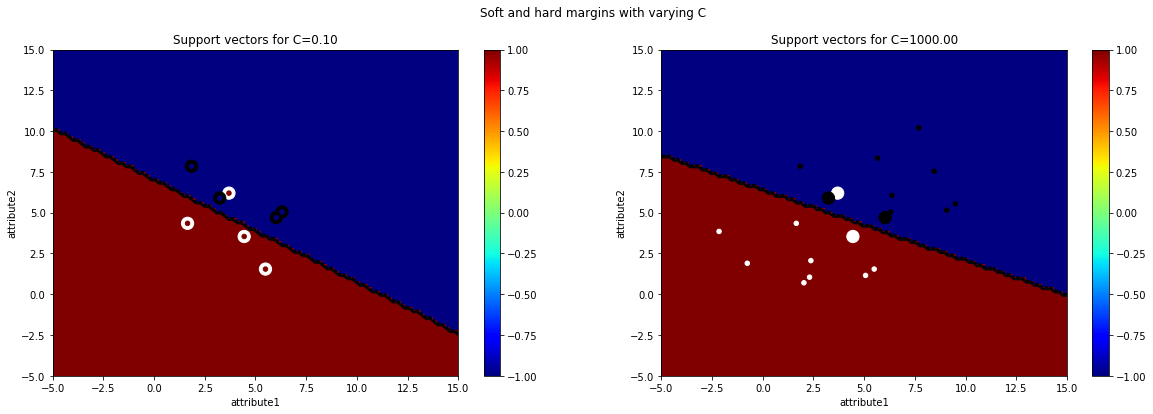

In [21]:
def plot_sv(C_values):
    figure(figsize=(20,6))
    suptitle('Soft and hard margins with varying C', fontsize=12)
    for i in range(len(C_values)): 
        subplot(1, len(C_values), i+1)
        linear_kernel=LinearKernel(feats_train, feats_train)
        svm1=LibSVM(C_values[i], linear_kernel, labels)
        svm1.train()
        vec1=svm1.get_support_vectors()
        X_=[]
        Y_=[]
        new_labels=[]
        for j in vec1:
            X_.append(traindata[0][j])
            Y_.append(traindata[1][j])
            new_labels.append(trainlab[j])
        out1=svm1.apply(RealFeatures(grid))
        z1=out1.get_labels().reshape((size, size))
        jet()
        c=pcolor(x1_, x2_, z1)
        contour(x1_ , x2_, z1, linewidths=1, colors='black', hold=True)
        colorbar(c)
        gray()
        scatter(X_, Y_, c=new_labels, s=150)
        scatter(traindata[0, :], traindata[1,:], c=labels, s=20)
        title('Support vectors for C=%.2f'%C_values[i])
        xlabel('attribute1')
        ylabel('attribute2')
        
        
C_values=[0.1, 1000]
plot_sv(C_values)

You can see that lower value of C causes classifier to sacrifice linear separability in order to gain stability, in a sense that influence of any single datapoint is now bounded by C. For hard margin SVM, support vectors are the points which are "on the margin". In the picture above, C=1000 is pretty close to hard-margin SVM, and you can see the highlighted points are the ones that will touch the margin. In high dimensions this might lead to overfitting. For soft-margin SVM, with a lower value of C, it's easier to explain them in terms of dual (equation $(2)$) variables. Support vectors are datapoints from training set which are are included in the predictor, ie, the ones with non-zero $\alpha_i$ parameter. This includes margin errors and points on the margin of the hyperplane.

### Binary classification using different kernels

Two-dimensional Gaussians are generated as data for this section.

$x_-\sim{\cal N_2}(0,1)-d$

$x_+\sim{\cal N_2}(0,1)+d$

and corresponding positive and negative labels. We create traindata and testdata with ```num``` of them being negatively and positively labelled in traindata,trainlab and testdata, testlab. For that we utilize Shogun's Gaussian Mixture Model class ([GMM](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGMM.html)) from which we sample the data points and plot them.

In [23]:
num=50;
dist=1.0;

gmm=GMM(2)
gmm.set_nth_mean(array([-dist,-dist]),0)
gmm.set_nth_mean(array([dist,dist]),1)
gmm.set_nth_cov(array([[1.0,0.0],[0.0,1.0]]),0)
gmm.set_nth_cov(array([[1.0,0.0],[0.0,1.0]]),1)

gmm.set_coef(array([1.0,0.0]))
xntr=array([gmm.sample() for i in range(num)]).T

gmm.set_coef(array([0.0,1.0]))
xptr=array([gmm.sample() for i in range(num)]).T

traindata=concatenate((xntr,xptr), axis=1)
trainlab=concatenate((-ones(num), ones(num)))

#shogun format features
feats_train=RealFeatures(traindata)
labels=BinaryLabels(trainlab)

In [24]:
gaussian_kernel=GaussianKernel(feats_train, feats_train, 10)
#Polynomial kernel of degree 2
poly_kernel=PolyKernel(feats_train, feats_train, 2, True)
linear_kernel=LinearKernel(feats_train, feats_train)

kernels=[gaussian_kernel, poly_kernel, linear_kernel]

In [25]:
#train machine
C=1
svm=LibSVM(C, gaussian_kernel, labels)
_=svm.train()

Now lets plot the contour output on a $-5...+5$ grid for 

1. The Support Vector Machines decision function $\mbox{sign}(f(x))$
2. The Support Vector Machines raw output $f(x)$
3. The Original Gaussian Mixture Model Distribution

/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'hold'
/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: The following kwargs were not used by contour: 'hold'


<Figure size 432x288 with 0 Axes>

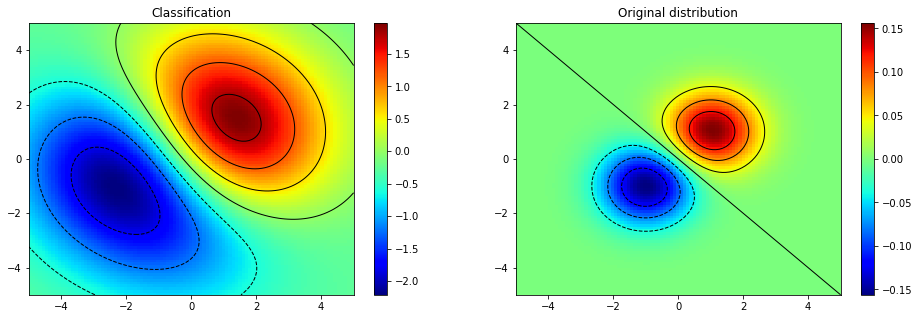

In [26]:
size=100
x1=linspace(-5, 5, size)
x2=linspace(-5, 5, size)
x, y=meshgrid(x1, x2)
grid=RealFeatures(array((ravel(x), ravel(y))))
grid_out=svm.apply(grid)
z=grid_out.get_labels().reshape((size, size))

jet()
figure(figsize=(16,5))

z=grid_out.get_values().reshape((size, size))

subplot(121)
title('Classification')
c=pcolor(x, y, z)
_=contour(x, y, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)

subplot(122)
title('Original distribution')
gmm.set_coef(array([1.0,0.0]))
gmm.set_features(grid)
grid_out=gmm.get_likelihood_for_all_examples()
zn=grid_out.reshape((size, size))
gmm.set_coef(array([0.0,1.0]))
grid_out=gmm.get_likelihood_for_all_examples()
zp=grid_out.reshape((size, size))
z=zp-zn
c=pcolor(x, y, z)
_=contour(x, y, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)

And voila! The SVM decision rule reasonably distinguishes the red from the blue points. Despite being optimized for learning the discriminative function maximizing the margin, the SVM output quality wise remotely resembles the original distribution of the gaussian mixture model.

Let us visualise the output using different kernels.

/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'hold'
  if sys.path[0] == '':


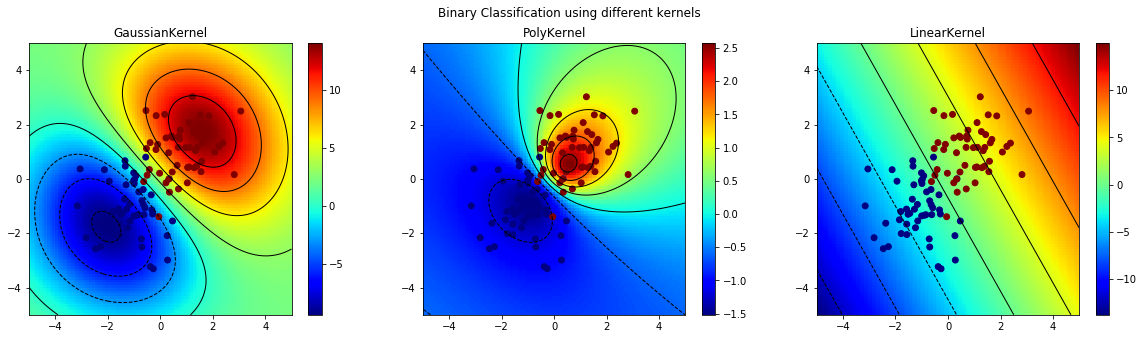

In [27]:
def plot_outputs(kernels):
    figure(figsize=(20,5))
    suptitle('Binary Classification using different kernels', fontsize=12)
    for i in range(len(kernels)):
        subplot(1,len(kernels),i+1)
        title(kernels[i].get_name())
        svm.set_kernel(kernels[i])
        svm.train()
        grid_out=svm.apply(grid)
        z=grid_out.get_values().reshape((size, size))
        c=pcolor(x, y, z)
        contour(x, y, z, linewidths=1, colors='black', hold=True)
        colorbar(c)
        scatter(traindata[0,:], traindata[1,:], c=trainlab, s=35)

plot_outputs(kernels)

### Kernel Normalizers

Kernel normalizers post-process kernel values by carrying out normalization in feature space. Since kernel based SVMs use a non-linear mapping, in most cases any normalization in input space is lost in feature space. Kernel normalizers are a possible solution to this. Kernel Normalization is not strictly-speaking a form of preprocessing since it is not applied directly on the input vectors but can be seen as a kernel interpretation of the preprocessing. The [CKernelNormalizer](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKernelNormalizer.html) class provides tools for kernel normalization. Some of the kernel normalizers in Shogun:

* [SqrtDiagKernelNormalizer](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CSqrtDiagKernelNormalizer.html) : This normalization in the feature space amounts to defining a new kernel $k'({\bf x},{\bf x'}) = \frac{k({\bf x},{\bf x'})}{\sqrt{k({\bf x},{\bf x})k({\bf x'},{\bf x'})}}$

* [AvgDiagKernelNormalizer](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CAvgDiagKernelNormalizer.html) : Scaling with a constant $k({\bf x},{\bf x'})= \frac{1}{c}\cdot k({\bf x},{\bf x'})$

* [ZeroMeanCenterKernelNormalizer](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CZeroMeanCenterKernelNormalizer.html) : Centers the kernel in feature space and ensures each feature must have zero mean after centering.

The `set_normalizer()` method of [CKernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKernel.html) is used to add a normalizer.
Let us try it out on the [ionosphere dataset](https://archive.ics.uci.edu/ml/datasets/Ionosphere) where we use a small training set of 30 samples to train our SVM. Gaussian kernel with and without normalization is used. See reference [1] for details.

In [28]:
from shogun import *

f = open('../../../data/toy/ionosphere.data')
mat = []
labels = []
# read data from file
for line in f:
    words = line.rstrip().split(',')
    mat.append([float(i) for i in words[0:-1]])
    if str(words[-1])=='g':
        labels.append(1)
    else:
        labels.append(-1)    

f.close()


mat_train=mat[:30]
mat_test=mat[30:110]

lab_train=BinaryLabels(array(labels[:30]).reshape((30,)))
lab_test=BinaryLabels(array(labels[30:110]).reshape((len(labels[30:110]),)))

feats_train = RealFeatures(array(mat_train).T)
feats_test = RealFeatures(array(mat_test).T)

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/toy/ionosphere.data'

In [ ]:
#without normalization
gaussian_kernel=GaussianKernel()
gaussian_kernel.init(feats_train, feats_train)
gaussian_kernel.set_width(0.1)

C=1
svm=LibSVM(C, gaussian_kernel, lab_train)
_=svm.train()
output=svm.apply(feats_test)

Err=ErrorRateMeasure()
error=Err.evaluate(output, lab_test)
print 'Error:', error

#set normalization
gaussian_kernel=GaussianKernel()
gaussian_kernel.set_normalizer(SqrtDiagKernelNormalizer())
gaussian_kernel.init(feats_train, feats_train)
gaussian_kernel.set_width(0.1)

svm.set_kernel(gaussian_kernel)
svm.train()
output=svm.apply(feats_test)

Err=ErrorRateMeasure()
error=Err.evaluate(output, lab_test)
print 'Error with normalization:', error

### Multiclass classification 

Multiclass classification can be done using SVM by reducing the problem to binary classification. More on multiclass reductions in [this notebook](http://www.shogun-toolbox.org/static/notebook/current/multiclass_reduction.html). [CGMNPSVM](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGMNPSVM.html) class provides a built in [one vs rest multiclass](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CMulticlassOneVsRestStrategy.html) classification using [GMNPlib](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGMNPLib.html). Let us see classification using it on four classes. [CGMM](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGMM.html) class is used to sample the data.

In [ ]:
num=30;
num_components=4
means=zeros((num_components, 2))
means[0]=[-1.5,1.5]
means[1]=[1.5,-1.5]
means[2]=[-1.5,-1.5]
means[3]=[1.5,1.5]

covs=array([[1.0,0.0],[0.0,1.0]])

gmm=GMM(num_components)
[gmm.set_nth_mean(means[i], i) for i in range(num_components)]
[gmm.set_nth_cov(covs,i) for i in range(num_components)]
gmm.set_coef(array([1.0,0.0,0.0,0.0]))
xntr=array([gmm.sample() for i in xrange(num)]).T
xnte=array([gmm.sample() for i in xrange(5000)]).T
gmm.set_coef(array([0.0,1.0,0.0,0.0]))
xntr1=array([gmm.sample() for i in xrange(num)]).T
xnte1=array([gmm.sample() for i in xrange(5000)]).T
gmm.set_coef(array([0.0,0.0,1.0,0.0]))
xptr=array([gmm.sample() for i in xrange(num)]).T
xpte=array([gmm.sample() for i in xrange(5000)]).T
gmm.set_coef(array([0.0,0.0,0.0,1.0]))
xptr1=array([gmm.sample() for i in xrange(num)]).T
xpte1=array([gmm.sample() for i in xrange(5000)]).T
traindata=concatenate((xntr,xntr1,xptr,xptr1), axis=1)
testdata=concatenate((xnte,xnte1,xpte,xpte1), axis=1)

l0 = array([0.0 for i in xrange(num)])
l1 = array([1.0 for i in xrange(num)])
l2 = array([2.0 for i in xrange(num)])
l3 = array([3.0 for i in xrange(num)])

trainlab=concatenate((l0,l1,l2,l3))
testlab=concatenate((l0,l1,l2,l3))

title('Toy data for multiclass classification')
_=jet()
_=scatter(traindata[0,:], traindata[1,:], c=trainlab, s=75)


In [ ]:
feats_train=RealFeatures(traindata)
labels=MulticlassLabels(trainlab)

Let us try the multiclass classification for different kernels.

In [ ]:
gaussian_kernel=GaussianKernel(feats_train, feats_train, 2)
poly_kernel=PolyKernel(feats_train, feats_train, 4, True)
linear_kernel=LinearKernel(feats_train, feats_train)

kernels=[gaussian_kernel, poly_kernel, linear_kernel]

In [ ]:
svm=GMNPSVM(1, gaussian_kernel, labels)
_=svm.train(feats_train)

size=100
x1=linspace(-6, 6, size)
x2=linspace(-6, 6, size)
x, y=meshgrid(x1, x2)
grid=RealFeatures(array((ravel(x), ravel(y))))
def plot_outputs(kernels):
    figure(figsize=(20,5))
    suptitle('Multiclass Classification using different kernels', fontsize=12)
    for i in range(len(kernels)):
        subplot(1,len(kernels),i+1)
        title(kernels[i].get_name())
        svm.set_kernel(kernels[i])
        svm.train(feats_train)
        grid_out=svm.apply(grid)
        z=grid_out.get_labels().reshape((size, size))
        c=pcolor(x, y, z)
        contour(x, y, z, linewidths=1, colors='black', hold=True)
        colorbar(c)
        scatter(traindata[0,:], traindata[1,:], c=trainlab, s=35)

plot_outputs(kernels)

The distinguishing properties of the kernels are visible in these classification outputs.

### References

[1] Classification in a Normalized Feature Space Using Support Vector Machines - Arnulf B. A. Graf, Alexander J. Smola, and Silvio Borer - IEEE TRANSACTIONS ON NEURAL NETWORKS, VOL. 14, NO. 3, MAY 2003

[2] Boyd, Stephen P.; Vandenberghe, Lieven (2004). Convex Optimization ([pdf](http://www.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf)). Cambridge University Press. ISBN 978-0-521-83378-3. Retrieved October 15, 2011.

[3] Lin, H., Lin, C., and Weng, R. (2007). A note on Platt's probabilistic outputs for support vector machines.